## Фреймворк PyTorch для разработки искусственных нейронных сетей   
### Урок 2. CNN and LSTM for human action recognition

1.	Приложен ноутбук, в котором реализованы функции для генерации из большого датасета меньшая его копия. Вам нужно перенести функции из этого ноутбука в класс датасет и сделать следующее:   
a.	Сгенерировать меньший датасет из 8-10 классов движения;  
b.	Обучить уже существующую модель (предварительно проанализировав какие параметры модели нужно изменить);   
c.	Изменить модель: посмотреть зависимость от количества LSTM модулей в нашей модели;  
d.	Сгенерировать другой датасет с меньшим количеством “кадров” в серии и сравнить улучшилось или ухудшилось качество предсказания. Провести несколько таких итераций, дать свою оценку уменьшению и увеличению кадров, назвать оптимальное, на ваш взгляд, их количество. Желательно сделать так, чтобы длина последовательности передавалась как атрибут класса. 

In [1]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:77% !important; }</style>"))

In [2]:
import os
import time
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

In [4]:
import torch
import torchvision
from torch import nn 
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

In [5]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
dst_path = "/content/drive/MyDrive/Colab Notebooks/my_projects/nturgbd_skeletons_s001_to_s017.zip"

In [15]:
# from zipfile import ZipFile
# zipfile = ZipFile(dst_path)
# zipfile.extractall()

In [16]:
data_path = "/content/nturgb+d_skeletons/"
broken_files_path = "/content/drive/MyDrive/Colab Notebooks/my_projects/NTURGB-D-master/Matlab/NTU_RGBD_samples_with_missing_skeletons.txt"

#### a.	Сгенерировать меньший датасет из 8-10 классов движения;   

In [17]:
training_subjects = list(range(0, 28)) # количество людей выполняющих действия
training_classes = [8, 10, 22, 23, 27, 21, 5, 17, 1, 32] # классы которые будем использовать для обучения, полный список прдставлен тут https://github.com/shahroudy/NTURGB-D
training_cameras = [1, 2, 3] 

max_body_true = 1
max_body_kinect = 1

# num_joint = 25
# max_frame = 300 # Длина отрезка которую мы вычленяем из большого датасета

In [18]:
class Generate_Dataset(Dataset):
    def __init__(self, data_path, broken_files_path=None, training_classes=None,
                 num_joint = 25, max_frame = 300, transform=None):
               
        def read_data(data_path, broken_files_path):
            labels = []
            files = []
            action_classes = {}
            counter = 0
            files_counter = {}
            
            with open(broken_files_path, 'r') as f:
                broken_files = f.read().split("\n")

            raw_files = os.listdir(data_path)
            num_frames = 0

            for filename in raw_files:
                if filename not in broken_files:
                    action_class = int(filename[filename.find('A') + 1:filename.find('A') + 4])
                    subject_id = int(filename[filename.find('P') + 1:filename.find('P') + 4])
                    camera_id = int(filename[filename.find('C') + 1:filename.find('C') + 4])
                    if action_class in training_classes and camera_id in training_cameras:  # and subject_id in training_subjects:
                        if action_class in action_classes:
                            if files_counter[action_class] < 120:
                                files.append([filename,action_classes[action_class]])
                                files_counter[action_class] = files_counter[action_class] + 1
                        else:
                            action_classes.update({action_class : counter})
                            files_counter.update({action_class : 1})
                            counter+=1
                            files.append([filename,action_classes[action_class]])
#                             labels.append([action_class])
            print("action classes: ", action_classes)
            print("action files: ", files_counter)

            return files, action_classes
        
        # Функция фильтр для того, что бы найти только координаты x,y,z(т.к. в датасете
        # хранится на порядок больше информации, нежели только координаты x,y,z)
        # (Остальные данные нам и не нужны, т.к. у нас нет ик-камер)
        def read_skeleton_filter(file):
            with open(file, 'r') as f:
                skeleton_sequence = {}
                skeleton_sequence['numFrame'] = int(f.readline())
                skeleton_sequence['frameInfo'] = []
                for t in range(skeleton_sequence['numFrame']):
                    frame_info = {}
                    frame_info['numBody'] = int(f.readline())
                    frame_info['bodyInfo'] = []

                    for m in range(frame_info['numBody']):
                        body_info = {}
                        body_info_key = [
                            'bodyID', 'clipedEdges', 'handLeftConfidence',
                            'handLeftState', 'handRightConfidence', 'handRightState',
                            'isResticted', 'leanX', 'leanY', 'trackingState'
                        ]
                        body_info = {
                            k: float(v)
                            for k, v in zip(body_info_key, f.readline().split())
                        }
                        body_info['numJoint'] = int(f.readline())
                        body_info['jointInfo'] = []
                        for v in range(body_info['numJoint']):
                            joint_info_key = [
                                'x', 'y', 'z', 'depthX', 'depthY', 'colorX', 'colorY',
                                'orientationW', 'orientationX', 'orientationY',
                                'orientationZ', 'trackingState'
                            ]
                            joint_info = {
                                k: float(v)
                                for k, v in zip(joint_info_key, f.readline().split())
                            }
                            body_info['jointInfo'].append(joint_info)
                        frame_info['bodyInfo'].append(body_info)
                    skeleton_sequence['frameInfo'].append(frame_info)

            return skeleton_sequence

        def read_xyz(file, max_body=1, num_joint=25):
            seq_info = read_skeleton_filter(file)
            data = np.zeros((max_body, seq_info['numFrame'], num_joint, 3))
            for n, f in enumerate(seq_info['frameInfo']):
                for m, b in enumerate(f['bodyInfo']):
                    for j, v in enumerate(b['jointInfo']):
                        if m < max_body and j < num_joint:
                            data[m, n, j, :] = [v['x'], v['y'], v['z']]

                        else:
                            pass

            return data
        
        
        def create_coords_blocks(test_file, chonk_len = 45):   
            frame_counter = 0
            new_labels = []
            new_frames = []
            blocks = []

            test_frames = read_xyz(data_path + test_file[0])[0]
            label = test_file[1]
            slice_len = chonk_len * int(len(test_frames)/chonk_len)


            for index in range(len(test_frames[:slice_len])):
                frame_counter += 1
                new_frames.append(test_frames[index].flatten())
                if frame_counter == chonk_len:
                    frame_counter = 0
                    blocks.append(np.array(new_frames))
                    new_labels = new_labels + [label]
                    new_frames = []


            return blocks, new_labels
        
        
        ##### список файлов с лейблами на каждый файл 
        working_files_with_labels, action_classes = read_data(data_path, broken_files_path)
        
        data = []
        labels = []
        ##########################################################################
        numbers = {x: 0 for x in range(len(action_classes))}  #####
        ##################################################################
        for file in working_files_with_labels:
            frames_blocks, label = create_coords_blocks(file)
            if label != [] and numbers[label[0]] <= 150:
                numbers[label[0]] = numbers[label[0]] + len(label)
                data = data + frames_blocks
                labels = labels + label
        data_np = np.asarray(data)
        labels_np = np.asarray(labels)

        data_sq = data_np.reshape(len(data_np), -1)
        data = pd.DataFrame(data_sq)
        labels = pd.DataFrame(labels_np)
        data['labels'] = labels
        

        self.data = data
        self.labels = data['labels'].astype('float32')
        self.transform = transform
        
           
    def __len__(self):
         return len(self.data)
        
        
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(45,75)
        label = self.labels[idx]
        if self.transform != None:
            item = transform(item)
        return (item, label) 

In [19]:
dataset = Generate_Dataset(data_path=data_path, broken_files_path=broken_files_path, 
                           training_classes=training_classes,num_joint = 25, 
                           max_frame = 300, transform=None)

action classes:  {21: 0, 8: 1, 5: 2, 10: 3, 23: 4, 17: 5, 27: 6, 32: 7, 1: 8, 22: 9}
action files:  {21: 120, 8: 120, 5: 120, 10: 120, 23: 120, 17: 120, 27: 120, 32: 120, 1: 120, 22: 120}


#### b. Обучить уже существующую модель (предварительно проанализировав какие параметры модели нужно изменить);

In [20]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.75*len(dataset)),
                                                                      len(dataset) - int(0.75*len(dataset))])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

In [21]:
class LSTM_net(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim,layer_num,batch_first=True)
        self.dr = torch.nn.Dropout2d(0.1)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        
        
    def forward(self,inputs):
        x = inputs
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [22]:
n_hidden = 128
n_joints = 25*3
n_categories = len(training_subjects)
n_layer = 2
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=28, bias=True)
)

In [23]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
#     print(output.topk(5))
    return training_subjects[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [24]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(), lr=learning_rate, momentum=0.9)

all_losses = []
start = time.time()
counter = 0
for epoch in range(600):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        labels = labels.type(torch.LongTensor).to(device)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = training_subjects[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses.append(current_loss / 25)
        current_loss = 0

epoch : 0 iter : 0 (0m 0s) 3.3240  / 11 ✗ (9)
epoch : 7 iter : 59 (0m 13s) 2.4790  / 5 ✗ (9)
epoch : 15 iter : 55 (0m 27s) 2.3833  / 7 ✗ (9)
epoch : 23 iter : 51 (0m 41s) 2.3954  / 5 ✗ (9)
epoch : 31 iter : 47 (0m 54s) 2.3274  / 7 ✗ (2)
epoch : 39 iter : 43 (1m 8s) 2.2275  / 5 ✗ (0)
epoch : 47 iter : 39 (1m 22s) 2.1950  / 7 ✗ (0)
epoch : 55 iter : 35 (1m 35s) 1.8877  / 9 ✗ (4)
epoch : 63 iter : 31 (1m 49s) 1.5013  / 9 ✓
epoch : 71 iter : 27 (2m 3s) 1.7997  / 5 ✗ (1)
epoch : 79 iter : 23 (2m 17s) 2.1923  / 5 ✓
epoch : 87 iter : 19 (2m 30s) 1.4235  / 2 ✗ (6)
epoch : 95 iter : 15 (2m 44s) 1.5165  / 5 ✓
epoch : 103 iter : 11 (2m 58s) 1.9079  / 7 ✗ (4)
epoch : 111 iter : 7 (3m 11s) 1.5903  / 1 ✓
epoch : 119 iter : 3 (3m 25s) 1.6031  / 5 ✓
epoch : 126 iter : 62 (3m 39s) 1.5444  / 4 ✗ (8)
epoch : 134 iter : 58 (3m 52s) 1.3447  / 5 ✓
epoch : 142 iter : 54 (4m 6s) 1.3500  / 7 ✗ (8)
epoch : 150 iter : 50 (4m 20s) 1.8159  / 2 ✓
epoch : 158 iter : 46 (4m 33s) 1.5754  / 8 ✗ (7)
epoch : 166 iter : 4

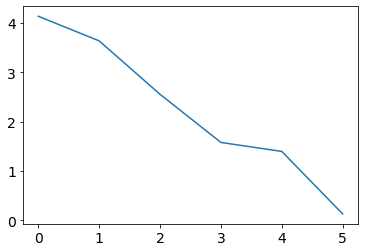

In [25]:
plt.plot(list(range(0, len(all_losses))), all_losses)
plt.show()

In [26]:
total = 0
right = 0
counter = 0

rnn.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        counter = counter + 1
        inputs, labels = data[0].to(device), data[1].to(device)  
        output = rnn(inputs.float())
        guess, guess_i = categoryFromOutput(output)
        category = training_subjects[int(labels[0])]
        
        if guess == category:
            right = right + 1


print('Accuracy of the network:  ',  (100 * right / counter))

Accuracy of the network:   62.79761904761905


#### c. Изменить модель: посмотреть зависимость от количества LSTM модулей в нашей модели;

In [101]:
class LSTM_net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layer_num):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, layer_num, batch_first=True)
        self.dr = torch.nn.Dropout2d(0.3)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self,inputs):
        x = inputs
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [102]:
n_hidden = 128*4
n_joints = 25*3
n_categories = len(training_subjects)
n_layer = 2
rnn = LSTM_net(n_joints, n_hidden, n_categories, n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 512, num_layers=2, batch_first=True)
  (dr): Dropout2d(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=28, bias=True)
)

In [98]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(), lr=learning_rate, momentum=0.9)

all_losses = []
start = time.time()
counter = 0
for epoch in range(600):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        labels = labels.type(torch.LongTensor).to(device)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = training_subjects[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses.append(current_loss / 25)
        current_loss = 0

epoch : 0 iter : 0 (0m 0s) 3.3105  / 14 ✗ (4)
epoch : 7 iter : 59 (0m 19s) 2.3225  / 7 ✗ (8)
epoch : 15 iter : 55 (0m 37s) 2.3094  / 5 ✗ (0)
epoch : 23 iter : 51 (0m 56s) 2.3328  / 7 ✗ (9)
epoch : 31 iter : 47 (1m 15s) 2.3877  / 5 ✗ (0)
epoch : 39 iter : 43 (1m 34s) 2.3304  / 9 ✗ (0)
epoch : 47 iter : 39 (1m 52s) 1.7880  / 9 ✗ (7)
epoch : 55 iter : 35 (2m 11s) 1.6977  / 7 ✗ (4)
epoch : 63 iter : 31 (2m 30s) 1.7256  / 1 ✗ (5)
epoch : 71 iter : 27 (2m 49s) 1.9274  / 1 ✗ (6)
epoch : 79 iter : 23 (3m 8s) 2.0593  / 5 ✓
epoch : 87 iter : 19 (3m 26s) 1.6175  / 6 ✗ (2)
epoch : 95 iter : 15 (3m 45s) 1.4483  / 7 ✗ (4)
epoch : 103 iter : 11 (4m 4s) 1.1736  / 4 ✗ (3)
epoch : 111 iter : 7 (4m 23s) 1.7089  / 7 ✗ (8)
epoch : 119 iter : 3 (4m 41s) 1.2680  / 3 ✗ (0)
epoch : 126 iter : 62 (5m 0s) 1.4332  / 4 ✓
epoch : 134 iter : 58 (5m 19s) 1.0849  / 2 ✓
epoch : 142 iter : 54 (5m 38s) 1.4446  / 5 ✗ (6)
epoch : 150 iter : 50 (5m 56s) 1.2806  / 0 ✓
epoch : 158 iter : 46 (6m 15s) 1.1743  / 8 ✗ (7)
epoch : 

In [99]:
total = 0
right = 0
counter = 0

rnn.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        counter = counter + 1
        inputs, labels = data[0].to(device), data[1].to(device)  
        output = rnn(inputs.float())
        guess, guess_i = categoryFromOutput(output)
        category = training_subjects[int(labels[0])]
        
        if guess == category:
            right = right + 1


print('Accuracy of the network(Модель задания "с"):  ',  (100 * right / counter))

Accuracy of the network(Модель задания "с"):   64.58333333333333


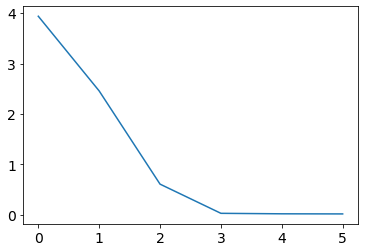

In [100]:
plt.plot(list(range(0, len(all_losses))), all_losses)
plt.show()

**Умеренное увеличение скрытых слоев в модели нейросети улучшает её точность:**   
Accuracy of the network(Модель задания "с" при n_hidden = 128 * 2):   62.79761904761905   
Accuracy of the network(Модель задания "с" при n_hidden = 128 * 3):   63.095238095238095   
Accuracy of the network(Модель задания "с" при n_hidden = 128 * 4):   64.88095238095238    
Accuracy of the network(Модель задания "с" при n_hidden = 128 * 5): 61.607142857142854   
Accuracy of the network(Модель задания "с" при n_hidden = 128 * 7):   61.904761904761905

**Увеличение значения Dropout2d в модели нейросети улучшает её точность:**  
Accuracy of the network(Модель задания "с" при Dropout2d(0.1)): 64.88095238095238   
Accuracy of the network(Модель задания "с" при Dropout2d(0.2)):   64.58333333333333    
Accuracy of the network(Модель задания "с" при Dropout2d(0.3)):   65.44542857142832  

#### d. Сгенерировать другой датасет с меньшим количеством “кадров” в серии и сравнить улучшилось или ухудшилось качество предсказания. Провести несколько таких итераций, дать свою оценку уменьшению и увеличению кадров, назвать оптимальное, на ваш взгляд, их количество. Желательно сделать так, чтобы длина последовательности передавалась как атрибут класса.

In [103]:
dataset = Generate_Dataset(data_path=data_path, broken_files_path=broken_files_path, 
                           training_classes=training_classes,num_joint = 25, 
                           max_frame = 400, transform=None)

action classes:  {21: 0, 8: 1, 5: 2, 10: 3, 23: 4, 17: 5, 27: 6, 32: 7, 1: 8, 22: 9}
action files:  {21: 120, 8: 120, 5: 120, 10: 120, 23: 120, 17: 120, 27: 120, 32: 120, 1: 120, 22: 120}


In [104]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.75*len(dataset)),
                                                                      len(dataset) - int(0.75*len(dataset))])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

In [105]:
rnn = LSTM_net(n_joints, n_hidden, n_categories, n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 512, num_layers=2, batch_first=True)
  (dr): Dropout2d(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=28, bias=True)
)

In [106]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(), lr=learning_rate, momentum=0.9)

all_losses = []
start = time.time()
counter = 0
for epoch in range(600):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        labels = labels.type(torch.LongTensor).to(device)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = training_subjects[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses.append(current_loss / 25)
        current_loss = 0

epoch : 0 iter : 0 (0m 0s) 3.3056  / 13 ✗ (9)
epoch : 7 iter : 59 (0m 18s) 2.3306  / 5 ✓
epoch : 15 iter : 55 (0m 37s) 2.2934  / 8 ✗ (0)
epoch : 23 iter : 51 (0m 56s) 2.2627  / 7 ✗ (4)
epoch : 31 iter : 47 (1m 15s) 2.3227  / 5 ✗ (2)
epoch : 39 iter : 43 (1m 34s) 2.2044  / 8 ✗ (9)
epoch : 47 iter : 39 (1m 52s) 1.6602  / 1 ✗ (2)
epoch : 55 iter : 35 (2m 11s) 1.8026  / 6 ✗ (3)
epoch : 63 iter : 31 (2m 30s) 1.8165  / 6 ✗ (7)
epoch : 71 iter : 27 (2m 49s) 1.4019  / 3 ✗ (8)
epoch : 79 iter : 23 (3m 8s) 1.8048  / 5 ✗ (1)
epoch : 87 iter : 19 (3m 26s) 1.4359  / 7 ✗ (9)
epoch : 95 iter : 15 (3m 45s) 1.4052  / 6 ✗ (8)
epoch : 103 iter : 11 (4m 5s) 1.7049  / 1 ✗ (5)
epoch : 111 iter : 7 (4m 23s) 1.5228  / 7 ✗ (3)
epoch : 119 iter : 3 (4m 42s) 1.8291  / 9 ✓
epoch : 126 iter : 62 (5m 1s) 1.2328  / 8 ✓
epoch : 134 iter : 58 (5m 19s) 1.0639  / 7 ✓
epoch : 142 iter : 54 (5m 38s) 1.5605  / 8 ✓
epoch : 150 iter : 50 (5m 57s) 1.2278  / 6 ✓
epoch : 158 iter : 46 (6m 16s) 1.3006  / 9 ✓
epoch : 166 iter : 4

In [107]:
total = 0
right = 0
counter = 0

rnn.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        counter = counter + 1
        inputs, labels = data[0].to(device), data[1].to(device)  
        output = rnn(inputs.float())
        guess, guess_i = categoryFromOutput(output)
        category = training_subjects[int(labels[0])]
        
        if guess == category:
            right = right + 1


print('Accuracy of the network(Модель задания "d"):  ',  (100 * right / counter))

Accuracy of the network(Модель задания "d"):   63.095238095238095


Accuracy of the network(Модель задания "d" при max_frame = 400):   Accuracy of the network(Модель задания "d"):   63.095238095238095

2.	Дополнительное задание:  
a.	http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption - 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months). Проделайте весь путь подготовки данных, создания датасета, разделения и обучения модели самостоятельно. Предсказывать нужно Global_active_power. Обратите внимание, что здесь задача регрессии, а не классификации, т.е. модель нужно изменить.  